# Sentiment Analysis

In [1]:
!pip install -U nltk scikit-learn pandas matplotlib numpy wordcloud

Requirement already up-to-date: scikit-learn in c:\program files (x86)\microsoft visual studio\shared\anaconda3_64\lib\site-packages (0.21.3)
  Using cached https://files.pythonhosted.org/packages/af/b2/51c178d516b85be51f3a3bd30c654453a3884a34d6329343555418b5d7cb/pandas-0.25.1-cp36-cp36m-win_amd64.whl
Requirement already up-to-date: matplotlib in c:\program files (x86)\microsoft visual studio\shared\anaconda3_64\lib\site-packages (3.1.1)
  Using cached https://files.pythonhosted.org/packages/2c/3a/2ffb91f7e310a0aa5cea890379291becfc65a915e32ed8d5088bf7544eda/numpy-1.17.2-cp36-cp36m-win_amd64.whl
Requirement already up-to-date: wordcloud in c:\program files (x86)\microsoft visual studio\shared\anaconda3_64\lib\site-packages (1.5.0)
  Found existing installation: nltk 3.4.3
    Uninstalling nltk-3.4.3:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\program files (x86)\\microsoft visual studio\\shared\\anaconda3_64\\lib\\site-packages\\nltk-3.4.3.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Read the csv

In [2]:
import pandas as pd

reviews = pd.concat([pd.read_csv('./files/reviews_en-pt_1.csv'), pd.read_csv('./files/reviews_en-pt_2.csv')], join='outer')
reviews['sentiment'] = reviews['sentiment'].map({'neg': 0, 'pos': 1})
reviews.drop(columns=["text_pt", "id"], inplace=True)
reviews.head(10)

,text_en,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures movies is not a fitting word fo...,0
5,"A funny thing happened to me while watching ""M...",0
6,This German horror film has to be one of the w...,0
7,"Being a long-time fan of Japanese film, I expe...",0
8,"""Tokyo Eyes"" tells of a 17 year old Japanese g...",0
9,Wealthy horse ranchers in Buenos Aires have a ...,0


# Preprocessing

In [3]:
import re
import nltk
from nltk.tokenize import WhitespaceTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.lima.laurentino\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a.lima.laurentino\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\a.lima.laurentino\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### 1. Cleaning:
    Clear and get only the main part from the dataset
    Ex: remove the tags of the html.
    Ex: filter the texts in PDF and etc.

In [4]:
def clean(text):
    # Remove the HTML tags
    text = re.sub("<!--?.*?-->","",text)
    text = re.sub("<.*?>","",text)
    
    return text

### 2. Normalization:
    Remove the pontuation, tags, put everything in same case and etc.

In [5]:
def normalize(text):
    # Convert to lower case
    text = text.lower()
    
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ",text)
    
    text = text.replace('  ', ' ')
    
    return text

### 3. Tokenization:
    Split the text in words spliting by the whitespaces.

In [6]:
def tokenizer(text):    
    tokenizer = WhitespaceTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens

### 4. Stop Words:
    They are words witch don't get no one meaning, they are just used to complement the context,
    and to connect the terms.
    Ex: 'i', 'you', 'in', 'out', 'are', 'the'

In [7]:
from nltk.corpus import stopwords

# Remove the stop words, they are words witch don't give no one especific meaning
def remove_stopwords(tokens):
    return [w for w in tokens if w not in stopwords.words("english")]

### 5. Stemming:
    Takes of the variation of the words and remove the finally to combine than.
    Ex: 'change', 'changing', 'changes' => 'chang'


### 6. Lemmatization:
    Takes the variation of the same word and convert to the same one (Noun).
    Ex: 'is', 'were', 'was' => 'be'
    Ex: 'ones' => 'one'

    Part of Speech(PoS) (Verb):
    Ex: 'bored' => 'bore'
    Ex: 'stating' => 'start'

In [11]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Remove the pural
# Remove the verb conjugation
def stem(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

# Remove the personality
def lem(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

### 7. Tag filtering
    Filter the words according with the sintaxe definition like a noun, verbs, adverbs e etc.

In [9]:
import nltk

# RB | RB | JJ | NN | NNP | JJ | JJS | IN | VB | VBZ | VBD | VBG

# IN = preposition/subordinating conjunction

# RB = adverb very, silently
# RBR = adverb, comparative better
# RBS = adverb, superlative best
# RP = particle give up

# IN = preposition/subordinating conjunction
# JJ = adjective ‘big’
# JJR = adjective, comparative ‘bigger’
# JJS = adjective, superlative ‘biggest’

# VB verb, base form take
# VBD verb, past tense took
# VBG verb, gerund/present participle taking
# VBN verb, past participle taken
# VBP verb, sing. present, non-3d take
# VBZ verb, 3rd person sing. present takes

# Filter using regular array
def filter_tokens(tokens):
    tags = [x[1] for x in nltk.pos_tag(list(tokens))]
    filters = ("RB", "RBR", "RBS", "RP", "JJ", "JJR", "JJS", "JJ", "VB")
    
    return [tokens[i] for i in range(len(tokens)) if tags[i] in filters]

# Bag of Words

In [36]:
all_words = " ".join(list(reviews.text_en.values[:5000]))

tokens = tokenizer(normalize(clean(all_words)))
print("> Tokenized!")

del all_words

tokens = remove_stopwords(tokens)
print("> Removed the stop words!")

# tokens = stem(tokens)
tokens = lem(tokens)
print("> Merged the term to the root form!")

# tokens = filter_tokens(tokens)
print("> Filtred by tags witch get more meaning!")

print("\nColection [:100]:\n")
print(tokens[:100])

> Tokenized!
> Removed the stop words!
> Merged the term to the root form!
> Filtred by tags witch get more meaning!

Colection [:100]:

['mr', 'costner', 'dragged', 'movie', 'far', 'longer', 'necessary', 'aside', 'terrific', 'sea', 'rescue', 'sequence', 'care', 'character', 'u', 'ghost', 'closet', 'costners', 'character', 'realized', 'early', 'forgotten', 'much', 'later', 'time', 'care', 'character', 'really', 'care', 'cocky', 'overconfident', 'ashton', 'kutcher', 'problem', 'come', 'kid', 'think', 'he', 'better', 'anyone', 'else', 'around', 'show', 'sign', 'cluttered', 'closet', 'obstacle', 'appears', 'winning', 'costner', 'finally', 'well', 'past', 'half', 'way', 'point', 'stinker', 'costner', 'tell', 'u', 'kutchers', 'ghost', 'told', 'kutcher', 'driven', 'best', 'prior', 'inkling', 'foreshadowing', 'magic', 'could', 'keep', 'turning', 'hour', 'example', 'majority', 'action', 'film', 'generic', 'boring', 'there', 'really', 'nothing', 'worth', 'watching', 'complete', 'waste', 'barely

### Get the frequency of the words

In [25]:
import nltk

frequency = nltk.FreqDist(tokens)

# Create the bag of words dataframe
bag_of_words = pd.DataFrame({"words": list(frequency.keys()), "frequency": list(frequency.values())})

del frequency

# Order by the Frequency
bag_of_words.sort_values(by="frequency", ascending=False, inplace=True)
bag_of_words.reset_index(drop=True, inplace=True)

# Save the bag of words
bag_of_words.to_csv('./files/bag-of-words.csv', index=True)

print(f"Back of words size: {bag_of_words.shape[0]}")

print(bag_of_words.shape[0])
bag_of_words.head(5)

Back of words size: 13718
13718


,words,frequency
0,bad,2473
1,even,2452
2,good,2270
3,really,1967
4,much,1669


### Plot the frequency in Word Cloud

In [26]:
def to_single_str(words, frequency):
    words = list(words)
    frequency = list(frequency)
    
    return " ".join([(words[i] + " ") * frequency[i] for i in range(len(frequency))])

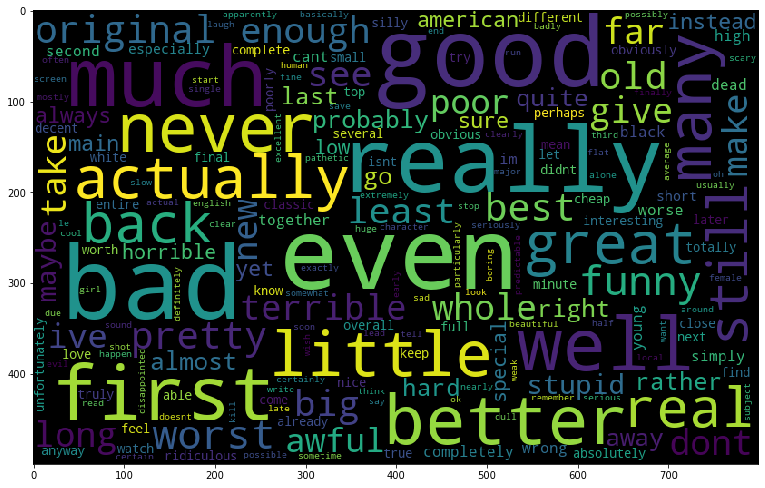

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(to_single_str(bag_of_words["words"], bag_of_words["frequency"]))

plt.figure(figsize=(13, 13))
plt.imshow(word_cloud)
plt.show()

del word_cloud

# Feature Selection

## TF-IDF

### Configs

In [29]:
# Load the dictinary
bag_of_words = pd.read_csv('./files/bag-of-words.csv')
bag_of_words_array = bag_of_words.words.values

# Get the inputs
reviews = pd.concat([pd.read_csv('./files/reviews_en-pt_1.csv'), pd.read_csv('./files/reviews_en-pt_2.csv')], join='outer')
reviews['sentiment'] = reviews['sentiment'].map({'neg': 0, 'pos': 1})
reviews.drop(columns=["text_pt", "id"], inplace=True)

inputs = reviews.text_en.values

### Implementation

In [30]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer


def tf_idf(txt, vocabulary=None):
    txt = list(txt)

    tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', vocabulary=vocabulary)
    txt_transformed = tf.fit(txt).transform(txt)

    return pd.DataFrame(txt_transformed.toarray(), columns=tf.get_feature_names())

In [31]:
tfidf = tf_idf(inputs, bag_of_words_array)
tfidf.head(10)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_extraction\text.py:1278: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


,bad,even,good,really,much,first,well,get,also,better,...,antipathetic,cleefs,writtenâ,insipidâ,bombastic,competed,berstein,ralfe,msr,moose
0,0.0,0.000000,0.00000,2.212256,2.286652,0.000000,2.212528,0.000000,0.000000,2.701125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.00000,4.424513,0.000000,0.000000,2.212528,0.000000,0.000000,8.103376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.00000,0.000000,4.573304,2.398623,0.000000,2.337175,2.388116,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.112969,0.00000,0.000000,0.000000,0.000000,2.212528,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,1.97721,6.636769,2.286652,0.000000,2.212528,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.388116,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,1.97721,4.424513,2.286652,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4.674350,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,2.112969,1.97721,0.000000,0.000000,0.000000,0.000000,0.000000,2.388116,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In [32]:
from sklearn.model_selection import train_test_split

x = tfidf.values
y = [[x] for x in reviews.sentiment.values]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, stratify = y)

### Dummy Classifier

In [33]:
from IPython.core.display import display, HTML
from sklearn.dummy import DummyClassifier

model = DummyClassifier()
model.fit(x_train, y_train)

accuracy = model.score(x_test, y_test) * 100
result = "Accuracy: %.2f" % (accuracy) + "%"

# Show the result in HTML
display(HTML(f'<h2>{result}</h2>'))

### Linear SVC

In [34]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.core.display import display, HTML

np.random.seed(5)

# Test a linear model
model = LinearSVC()
model.fit(x_train, y_train)

accuracy = model.score(x_test, y_test) * 100
result = "Accuracy: %.2f" % (accuracy) + "%"

# Show the result in HTML
display(HTML(f'<h2>{result}</h2>'))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.core.display import display, HTML

np.random.seed(5)

# Test a linear model
model = MultinomialNB()
model.fit(x_train, y_train)

accuracy = model.score(x_test, y_test) * 100
result = "Accuracy: %.2f" % (accuracy) + "%"

# Show the result in HTML
display(HTML(f'<h2>{result}</h2>'))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
